# Detection of Gravitational Waves

<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/Project_GravitationalWaves-BBHM.jpg" width=500 align=left></img><br>

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import warnings
warnings.filterwarnings('ignore')

In [145]:
# imports for neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pandas as pd
from random import shuffle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from nnAudio.Spectrogram import CQT1992v2
import torch
from matplotlib.gridspec import GridSpec
from sklearn import metrics



## <span style="color:Orange">Overview</span>

Gravitational waves are predicted by Einstein's general theory of relativity in 1916, which posits that gravity warps space and time, causing objects traveling through it to follow a curved path. By analogy to electromagnetism, time variation of the mass quadrupole moment of the source is expected to lead to transverse waves of spatial strain. The existence of GW was first demonstrated in 1974 by the discovery of a binary system composed of a pulsar in orbit around a neutron star by Hulse and Taylor [[1]](https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H/abstract). However, direct detections of GW did not arrive until 2016. In that year, The LIGO (The Laser Interferometer Gravitational-Wave Observatory) collaboration reported the first direct detection of GW from a binary black hole system merging to form a single black hole [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102). The observations reported in this paper and futher GW detections wprovide new tests of generay relativity in its strong-field regime, and GW observations have become an important new means to learn about the Universe.

In this project, you will reproduce the results reported in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102) with LIGO open data. You will analyze a particular GW event GW150914 (the first GW ever detected). 

You will also explore machine learning methods applied to simulated LIGO data for the detection of GWs. 

## <span style="color:Orange">Data Sources</span>

This project is based on the open data from the LIGO Scientific Collaboration. The data is hosted by the Gravitational Wave Open Science Center (GWOSC), formerly known as the LIGO Open Science Center, was created to provide public access to gravitational-wave data products. The collaborations running LIGO, Virgo, GEO600, and KAGRA have all agreed to use GWOSC services as the primary access points for public data products. This collaborative approach benefits users by creating a uniform interface to access data from multiple observatories, and provides cost savings to the various observatories by sharing the tools, services, and human resources.

GWOSC Data Repository: https://gwosc.org/data

You will also used simulated GW challenge data from https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/data to explore ML methods for GW detection. 

## <span style="color:Orange">Questions</span>

### <span style="color:LightGreen">Question 01</span>

 What are gravity waves? How are they generated? How fast do they propogate? What can they tell us about the early universe?

Gravity waves are ripples or warping of the "fabric" of spacetime. They are caused by massive accelerating objects bending the spacetime around them. When two massive objects such as black holes or neutron stars spiral in orbit until collision, their death spiral results in ripples of gravity waves being sent outwards. Gravity waves can also be emitted by neutron stars that aren't perfect spheres rotating, as well as stochastic signals that can date back to the Big Bang. Gravity waves move at the speed of light. Gravity waves don't scatter and travel unimpeded, so any gravity waves formed in the early universe can still be travelling, waiting for us to detect them.

Source: https://www.ligo.caltech.edu/page/what-are-gw

### <span style="color:LightGreen">Question 02</span>

How are they detected? Describe the LIGO experiment and the three detector sites (). 

Gravity waves are detected using interferometers, very similar to the Michelson-Morley experiment. However, the LIGO interferometers have arms that are 4km long. They shoot a laser which gets split and sent down two different arms. There are mirrors at the end of the arms which bounce the split light back. The light gets recombined to create interference patterns. LIGO uses two additional features to enable the detection of gravity waves: Fabry Perot cavities and Power Recycling Mirrors. Both of these use mirrors, the first uses mirrors to increase the effective distance travelled by photons before being detected, allowing gravity waves to make more of an impace on their travel distance. The other keeps the light energy in the system, enabling more precise measurements.

There are two LIGO detector sites: LIGO Hanford in Washington state, and LIGO Livingston in Louisiana. Being separated by 3000 miles prevents them from getting noise from the same sources at the same time. There are other sites that have interferometers, such as Virgo, located in Italy.


Source: https://www.ligo.caltech.edu/page/ligos-ifo

## <span style="color:Orange">Filtering a TimeSeries to detect gravitational waves</span>


### <span style="color:Violet">Importing and Setup</span>

You will need to install and import the `gwpy` module for data acquisition and helper functions

Please note, you will have to restart runtime to run your code after pip installing the `gwpy` module.

The raw ‘strain’ output of the LIGO detectors is recorded as a `TimeSeries` with contributions from a large number of known and unknown noise sources, as well as possible gravitational wave signals.

In order to uncover a real signal we need to filter out noises that otherwise hide the signal in the data. We can do this by using the `gwpy.signal` module to design a digital filter to cut out low and high frequency noise, as well as notch out fixed frequencies polluted by known artefacts.

First we download the raw LIGO-Hanford (H1) strain data from the GWOSC public archive:

In [2]:
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)

Next we can design a zero-pole-gain (ZPK) filter to remove the extranious noise.

First we import the `gwpy.signal.filter_design` module and create a bandpass() filter to remove both low and high frequency content

In [3]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate)

Now we want to combine the bandpass with a series of `notch()` filters, so we create those for the first three harmonics of the 60 Hz AC mains power:

In [4]:
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]

and concatenate each of our filters together to create a single ZPK model:

In [5]:
zpk = filter_design.concatenate_zpks(bp, *notches)

Now, we can apply our combined filter to the data, using `filtfilt=True` to filter both backwards and forwards to preserve the correct phase at all frequencies

In [6]:
hfilt = hdata.filter(zpk, filtfilt=True)

Note: The filter_design methods return digital filters by default, so we apply them using TimeSeries.filter. If we had analogue filters (perhaps by passing `analog=True` to the filter design method), the easiest application would be `TimeSeries.zpk`

The filter_design methods return infinite impulse response filters by default, which, when applied, corrupt a small amount of data at the beginning and the end of our original `TimeSeries`. We can discard those data using the `crop()` method (for consistency we apply this to both data series):

In [7]:
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

Finally, we can `plot()` the original and filtered data, adding some code to prettify the figure:

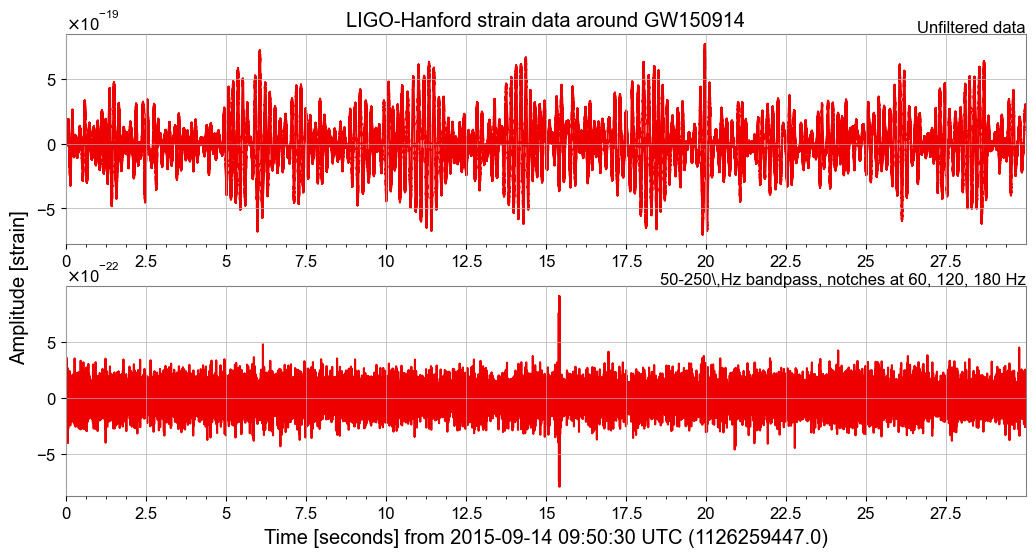

In [8]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

We see now a spike around 16 seconds into the data, so let’s zoom into that time (and prettify):

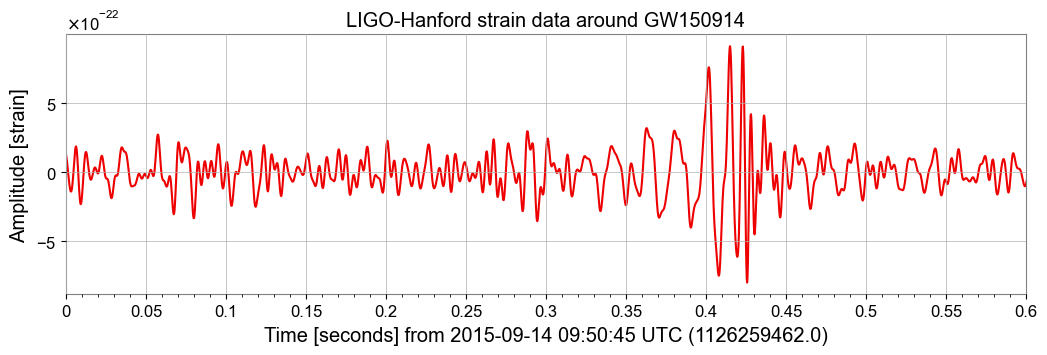

In [21]:
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()

### <span style="color:LightGreen">Question 03</span>

Congratulations, you have succesfully filtered LIGO data to uncover the first ever directly-detected gravitational wave signal, GW150914! 

But wait, what about LIGO-Livingston (L1)? Your task is to add data from LIGO-Livingston to our figure by following the same procedure. You can load the data with:

`ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)`

___Hint___: The article announcing the detection told us that the signals were separated by a certain time between the detectors, and that the relative orientation of those detectors means that we need to invert the data from one before comparing them. If you do it right, you should be able to generate a comparison plot resembling the upper-right plot in Figure 1 in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102).

In [10]:
ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)

In [12]:
lfilt = ldata.filter(zpk, filtfilt=True)
ldata = ldata.crop(*ldata.span.contract(1))
lfilt = lfilt.crop(*lfilt.span.contract(1))

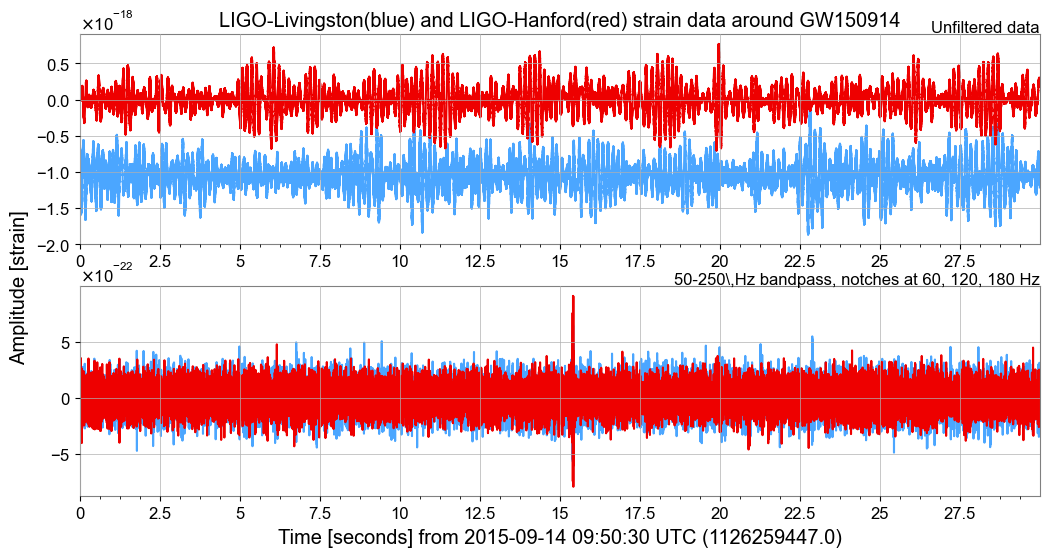

In [24]:
plot = Plot(ldata, lfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-livingston')
ax1, ax2 = plot.axes
ax1.plot(hdata, color='gwpy:ligo-hanford')
ax2.plot(hfilt, color='gwpy:ligo-hanford')
ax1.set_title('LIGO-Livingston(blue) and LIGO-Hanford(red) strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

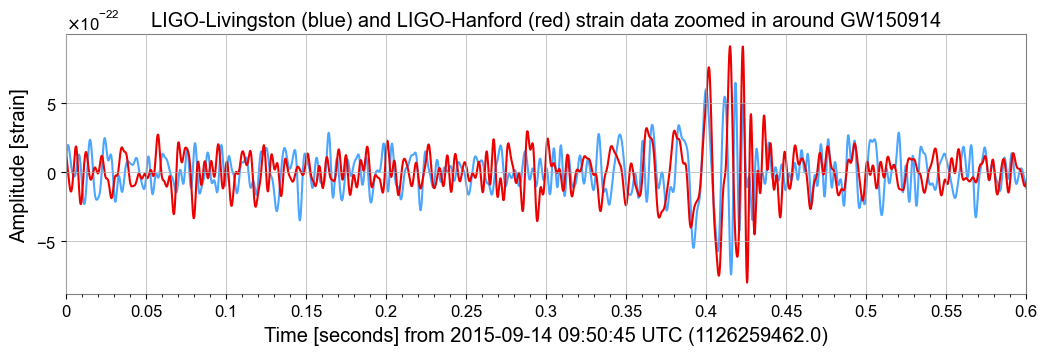

In [27]:
plot2 = lfilt.plot(color='gwpy:ligo-livingston')
ax = plot2.gca()
ax.plot(hfilt, color='gwpy:ligo-hanford')
ax.set_title('LIGO-Livingston (blue) and LIGO-Hanford (red) strain data zoomed in around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()

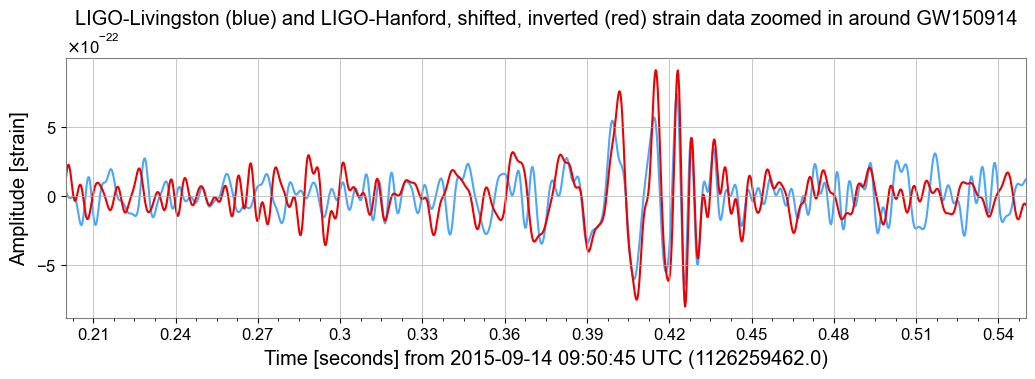

In [41]:
invertl = lfilt * -1
invertl.shift(0.007)
plot3 = invertl.plot(color='gwpy:ligo-livingston')
ax = plot3.gca()
ax.set_title('LIGO-Livingston (blue) and LIGO-Hanford, shifted, inverted (red) strain data zoomed in around GW150914')

ax.plot(hfilt, color='gwpy:ligo-hanford')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462.2, 1126259462.55)
ax.set_xscale('seconds', epoch=1126259462)

### <span style="color:Violet">Data in the Frequency Domain</span>

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz). So, if you want to know the root-mean-square (rms) strain noise in a frequency band, integrate (sum) the squares of the ASD over that band, then take the square-root.

You will see that the unfiltered LIGO data are dominated by low frequency noise; there is no way to see a signal here, without the signal processing you have done previously.

Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

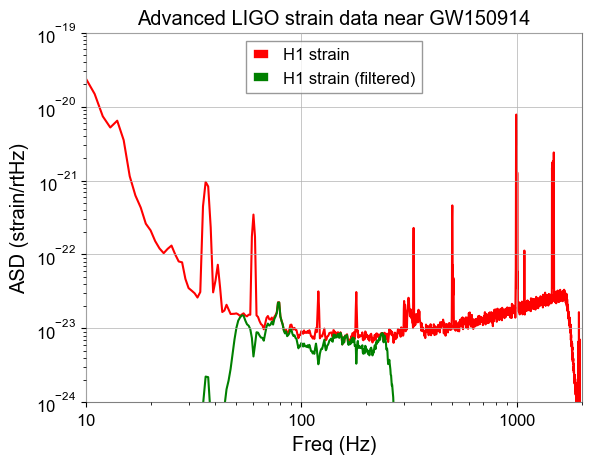

In [42]:
# sampling rate:
fs = 4096

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1data, freqs = mlab.psd(hdata, Fs = fs, NFFT = NFFT)
Pxx_H1filt, freqs = mlab.psd(hfilt, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1data = interp1d(freqs, Pxx_H1data)
psd_H1filt = interp1d(freqs, Pxx_H1filt)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_H1data),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_H1filt),'g',label='H1 strain (filtered)')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')

NOTE that we only plot the data between fmin = 10 Hz and fmax = 2000 Hz.

Below fmin, the data are not properly calibrated. That's OK, because the noise is so high below fmin that LIGO cannot sense gravitational wave strain from astrophysical sources in that band.

The sample rate is fs = 4096 Hz (2^12 Hz), so the data cannot capture frequency content above the Nyquist frequency = fs/2 = 2048 Hz. That's OK, because GW150914 only has detectable frequency content in the range 20 Hz - 300 Hz.

You can see strong spectral lines in the data; they are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

### <span style="color:LightGreen">Question 04</span>

Generate the analogous ASD vs Frequency plot to the one above for the LIGO-Livingston (L1) data and generate a plot that directly compares the H1 and L1 data (analogous to Figure 3 in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)).

Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

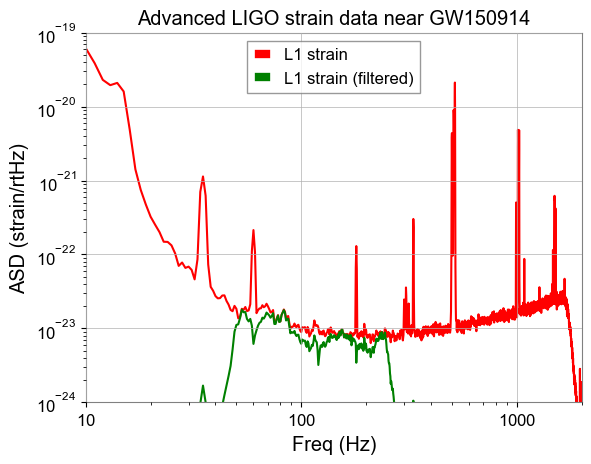

In [43]:
# sampling rate:
fs = 4096

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_L1data, freqs = mlab.psd(ldata, Fs = fs, NFFT = NFFT)
Pxx_L1filt, freqs = mlab.psd(lfilt, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_L1data = interp1d(freqs, Pxx_L1data)
psd_L1filt = interp1d(freqs, Pxx_L1filt)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_L1data),'r',label='L1 strain')
plt.loglog(freqs, np.sqrt(Pxx_L1filt),'g',label='L1 strain (filtered)')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')

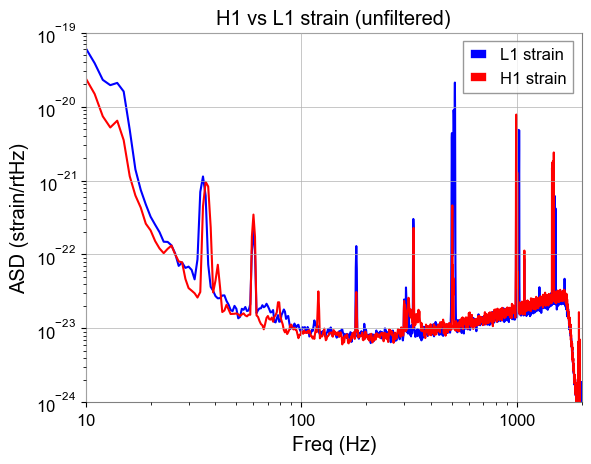

In [47]:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_L1data),'b',label='L1 strain')
plt.loglog(freqs, np.sqrt(Pxx_H1data),'r',label='H1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.title("H1 vs L1 strain (unfiltered)")
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend()

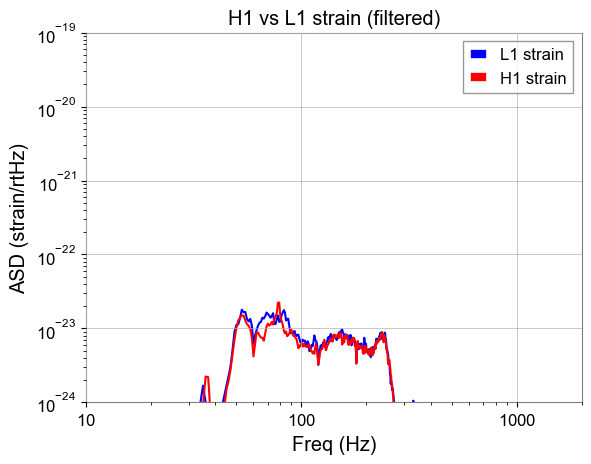

In [48]:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_L1filt),'b',label='L1 strain')
plt.loglog(freqs, np.sqrt(Pxx_H1filt),'r',label='H1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.title("H1 vs L1 strain (filtered)")
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend()

### <span style="color:Violet">Evolution of the Frequency over Time: The Spectrogram</span>

One of the most useful methods of visualising gravitational-wave data is to use a spectrogram, highlighting the frequency-domain content of some data over a number of time steps. We can calculate a Spectrogram using the spectrogram() method of the TimeSeries over a 2-second stride with a 1-second FFT and # .5-second overlap (50%). Note that `TimeSeries.spectrogram()` returns a Power Spectral Density (PSD) Spectrogram by default, so we use the ** (1/2.) to convert this into a (more familiar) Amplitude Spectral Density.

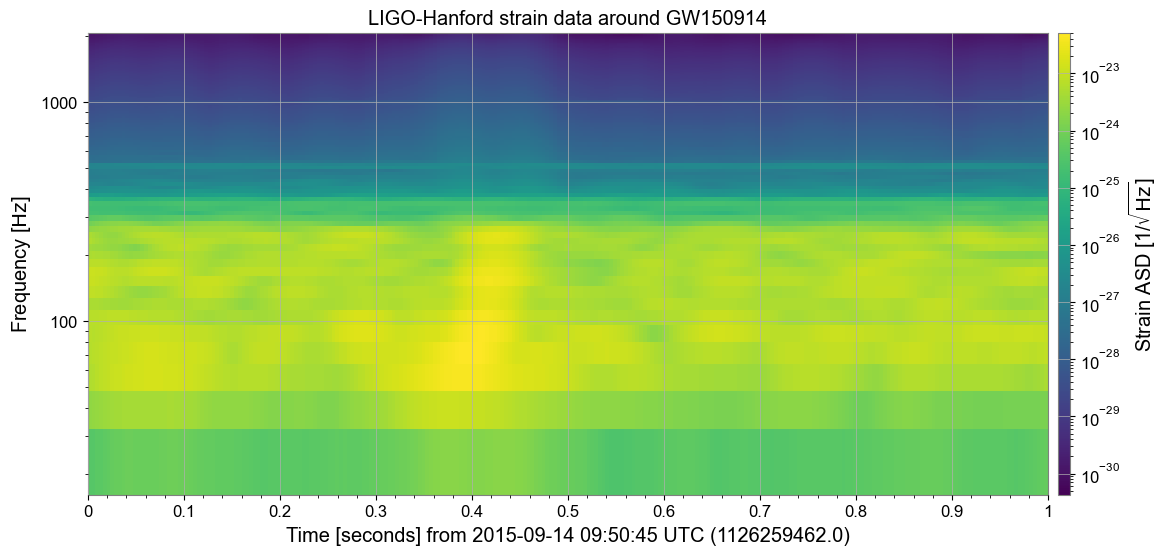

In [49]:
specgram = hfilt.spectrogram2(fftlength=1/16., overlap=15/256.) ** (1/2.)
specgram = specgram.crop_frequencies(20)  # drop everything below highpass

plot = specgram.plot(norm='log', cmap='viridis', yscale='log')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_xlim(1126259462, 1126259463)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')
plot.show()

There is a hint of the famous "chirp" signal (around $t=0.4$ in the plot) representing the spin-down and binary BH merger for the `GW150914` discovery event. With some additional filtering that you will do in the next problem, we can make this much more visible. 

### <span style="color:Violet">Q-transform</span>

One of the most useful tools for filtering and visualising short-duration features in a TimeSeries is the Q-transform. This is regularly used by the Detector Characterization working groups of the LIGO Scientific Collaboration and the Virgo Collaboration to produce high-resolution time-frequency maps of transient noise (glitches) and potential gravitational-wave signals.

This algorithm was used to visualise the first ever gravitational-wave detection `GW150914`, so we can reproduce that result (bottom panel of Figure 1 in n [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)) here.

### <span style="color:LightGreen">Question 05</span>

With guidance from https://gwpy.github.io/docs/2.1.3/examples/timeseries/qscan, generate and display the Q-filtered spectrogram plots for both the LIGO-Hanford and LIGO-Livingston data. Use the same time and frequency ranges as in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102). Specifically, perform the Q-transform for $t=0.2$ seconds around the GW event `GW150914` and set the time-axis limits to be `-0.17 seconds` before the event to `0.03 seconds` after the event. 

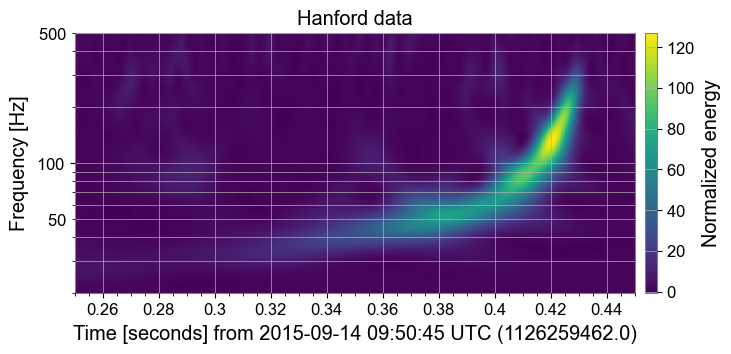

In [62]:
event = 1126259462.42
qspecgram = hdata.q_transform(outseg=(event-0.17, event+0.03))
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
ax.set_title("Hanford data")
plot.show()

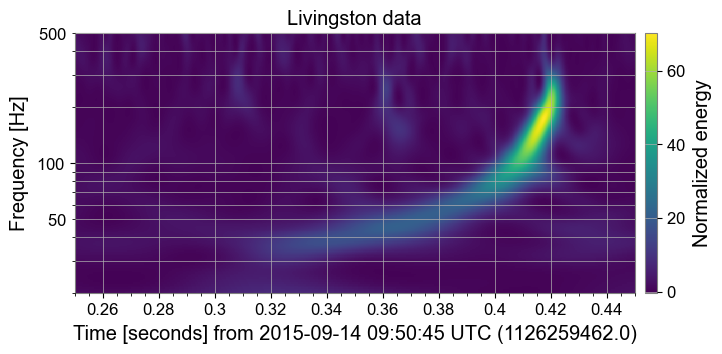

In [63]:
qspecgram = ldata.q_transform(outseg=(event-0.17, event+0.03))
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_title("Livingston data")
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

### <span style="color:Violet">Machine Learning Approaches to Gravitational Wave Detection</span>

Given the subtle nature of the GW signals, machine learning methods can be powerful to find gravitational wave signals from binary black hole collisions. Next you will develop and explore one or more ML methods for GW detection using simulated waveforms from the [G2Net Gravitational Wave Detection Challenge](https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/overview).

### <span style="color:LightGreen">Question 06</span>

Develop, train and evaluate an ML model used to detect GW signals from the mergers of binary black holes. Specifically, you'll build a model to analyze simulated GW time-series data from a network of Earth-based detectors.

Some examples could be found [here](https://diposit.ub.edu/dspace/bitstream/2445/201012/1/DANA%20RU%C3%8DZ%20ABEL_7999646.pdf) which use a `Conv1D` network and compare with a pre-trained generative Transformer model. Other challenge participant solutions can be found (here)[https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/code]. You have a lot of freedom in answer this question. A CNN seems like a good start, but feel free to explore ML methods here. Its more important to get one working ML model to classify signal and background waveforms then to thinly "play" with several models. 

You can take inspiration and code from publically-available challenge solutions, but you might cite all sources for full credit!

In [72]:
train_labels = pd.read_csv("./tmp_data/g2net-gravitational-wave-detection/training_labels.csv")
sample_submission = pd.read_csv("./tmp_data/g2net-gravitational-wave-detection/sample_submission.csv")

In [73]:
def id2path(idx, is_train = True):
    path = "./tmp_data/g2net-gravitational-wave-detection"
    
    if is_train:
        path += "/train/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"
        
    else:
        path += "/test/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"
        
    return path

In [79]:
def increase_dimension(idx, is_train, transform = CQT1992v2(sr = 2048, hop_length = 64, fmin = 20, fmax = 500)):
    wave = np.load(id2path(idx, is_train))
    wave = np.concatenate(wave, axis = 0)
    bHP, aHP = signal.butter(8, (20, 500), btype='bandpass', fs=2048)
    window = signal.windows.tukey(4096*3, 0.2)
    wave *= window
    wave = signal.filtfilt(bHP, aHP, wave)
    wave = wave / np.max(wave)
    wave = torch.from_numpy(wave).float()
    image = transform(wave)
    image = np.array(image)
    image = np.transpose(image, (1, 2, 0))
    
    return image

CQT kernels created, time used = 0.0047 seconds


In [82]:
increase_dimension(train_labels["id"][0], is_train = True)

array([[[1.7137997e-02],
        [2.1535369e-02],
        [3.0901700e-02],
        ...,
        [3.9685190e-02],
        [3.6446162e-02],
        [3.5359036e-02]],

       [[4.1911699e-02],
        [4.2736538e-02],
        [4.4809308e-02],
        ...,
        [4.0882666e-02],
        [2.5828170e-02],
        [1.8566245e-02]],

       [[6.7073125e-03],
        [6.9515705e-03],
        [8.5122623e-03],
        ...,
        [5.9417229e-02],
        [5.0562825e-02],
        [4.7443658e-02]],

       ...,

       [[1.5159989e-05],
        [8.9748653e-05],
        [1.8420524e-04],
        ...,
        [5.6797126e-04],
        [9.9984471e-05],
        [1.9369303e-05]],

       [[1.3173180e-05],
        [1.4992683e-04],
        [2.2250894e-04],
        ...,
        [6.8991684e-04],
        [6.0786067e-05],
        [2.4549070e-06]],

       [[1.1499248e-05],
        [9.8939054e-05],
        [2.0353393e-04],
        ...,
        [5.7911524e-04],
        [9.9786033e-05],
        [1.8361869e-05]]

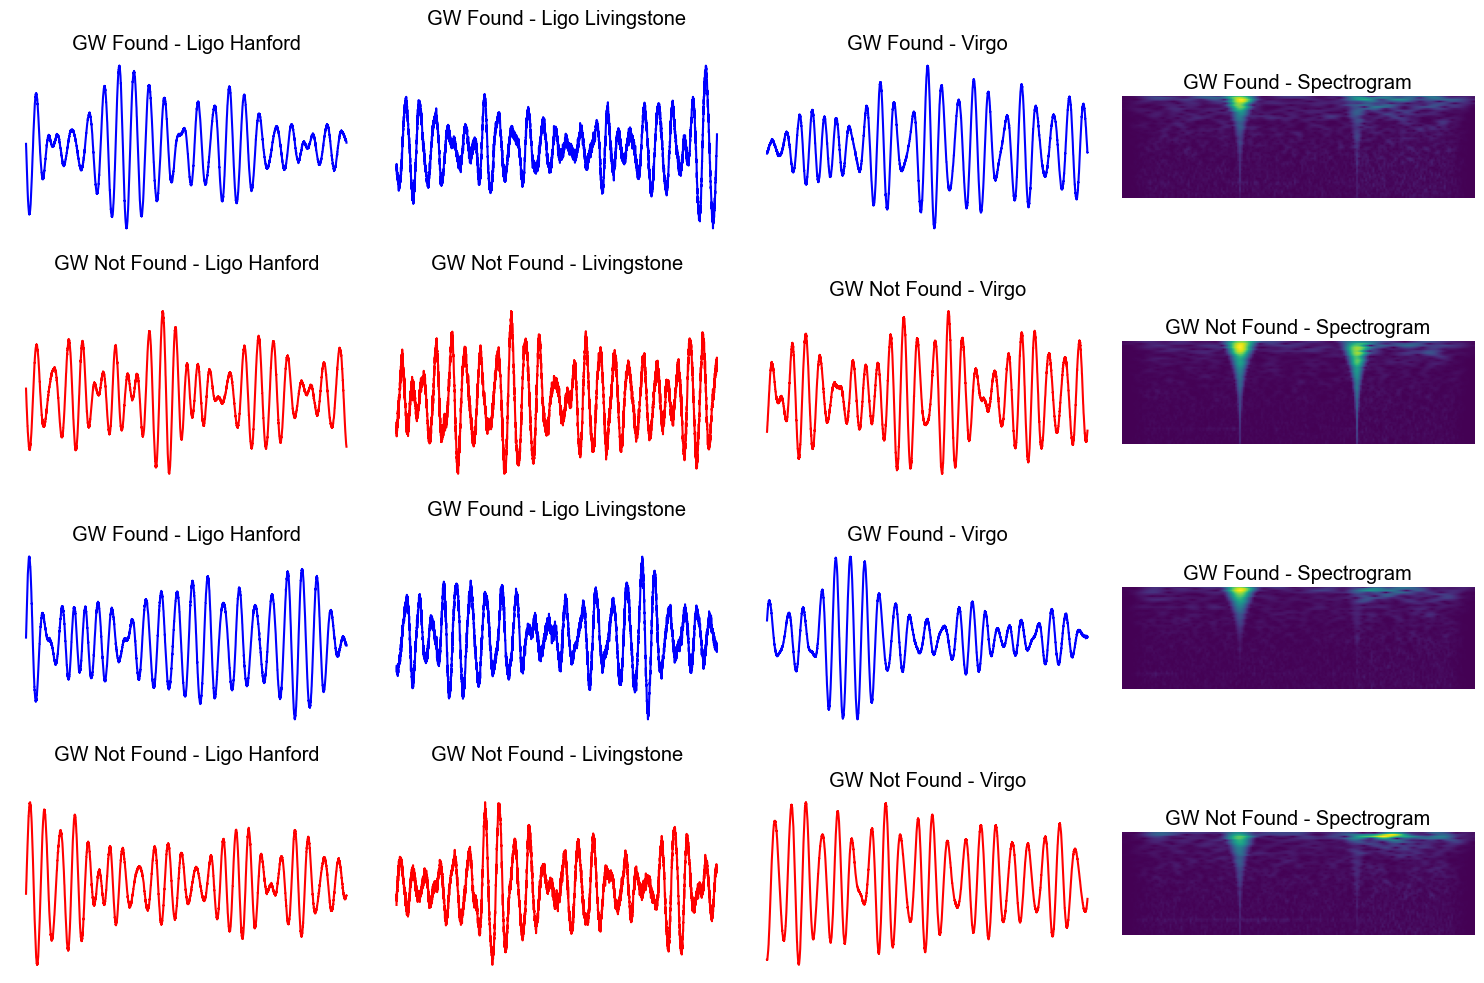

In [85]:
targets = train_labels[train_labels["target"] == 0]["id"].head(2)
no_targets = train_labels[train_labels["target"] == 1]["id"].head(2)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 4, figure=fig)

for i, (target, no_target) in enumerate(zip(targets, no_targets)):
    # Subplot para GW Found (gráfico de líneas)
    ax1 = fig.add_subplot(gs[i*2, 0])
    ax1.plot(np.load(id2path(target))[1, :], color='blue')
    ax1.set_title("GW Found - Ligo Hanford")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[i*2, 1])
    ax2.plot(np.load(id2path(target))[2, :], color='blue')
    ax2.set_title("GW Found - Ligo Livingstone")
    ax2.set_axis_off()

    ax3 = fig.add_subplot(gs[i*2, 2])
    ax3.plot(np.load(id2path(target))[0, :], color='blue')
    ax3.set_title("GW Found - Virgo")
    ax3.set_axis_off()
    
    ax4 = fig.add_subplot(gs[i*2, 3])
    ax4.imshow(increase_dimension(target, is_train=True))
    ax4.set_title("GW Found - Spectrogram")
    ax4.set_axis_off()
    

    # Subplot para GW Not Found (gráfico de líneas)
    ax5 = fig.add_subplot(gs[i*2 + 1, 0])
    ax5.plot(np.load(id2path(no_target))[1, :], color='red')
    ax5.set_title("GW Not Found - Ligo Hanford")
    ax5.set_axis_off()

    ax6 = fig.add_subplot(gs[i*2 + 1, 1])
    ax6.plot(np.load(id2path(no_target))[2, :], color='red')
    ax6.set_title("GW Not Found - Livingstone")
    ax6.set_axis_off()

    ax7 = fig.add_subplot(gs[i*2 + 1, 2])
    ax7.plot(np.load(id2path(no_target))[0, :], color='red')
    ax7.set_title("GW Not Found - Virgo")
    ax7.set_axis_off()

    ax8 = fig.add_subplot(gs[i*2 + 1, 3])
    ax8.imshow(increase_dimension(no_target, is_train=True))
    ax8.set_title("GW Not Found - Spectrogram")
    ax8.set_axis_off()

plt.tight_layout()
plt.show()

In [86]:
import math
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, y = None, batch_size = 256, shuffle = True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if y is not None:
            self.is_train = True
        else:
            self.is_train = False
            
        self.y = y
        
    def __len__(self):
        return math.ceil(len(self.data)/ self.batch_size)
    
    def __getitem__(self, ids):
        batch_data = self.data[ids * self.batch_size : (ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size : (ids + 1) * self.batch_size]
            
        batch_x = np.array([increase_dimension(x, self.is_train) for x in batch_data])
        batch_x = np.stack(batch_x)
        
        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.data, self.y))
            shuffle(ids_y)
            self.data, self.y = list(zip(*ids_y))

In [157]:
train_idx =  train_labels['id'].values
y = train_labels['target'].values
test_idx = sample_submission['id'].values

x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.05,random_state=42,stratify=y)

train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_valid,y_valid)
test_dataset = Dataset(test_idx)

In [161]:
def CreateModel():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(56, 193, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [162]:
model = CreateModel()
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 54, 191, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 27, 95, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 25, 93, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 10, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 5, 22, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 14080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     1,802,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,895,169 (7.23 MB)

 Trainable params: 1,895,169 (7.23 MB)

 Non-trainable params: 0 (0.00 B)

In [163]:
model.fit(train_dataset, epochs = 2, validation_data = valid_dataset)

Epoch 1/2
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 4790s 2s/step - accuracy: 0.7114 - loss: 0.5334 - val_accuracy: 0.7532 - val_loss: 0.4772
Epoch 2/2
  98/2079 ━━━━━━━━━━━━━━━━━━━━ 1:07:34 2s/step - accuracy: 0.7576 - loss: 0.4772

In [153]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)
probabilities = preds
# print(probabilities)
submission = pd.DataFrame({'id':sample_submission['id'][0],'target':preds})


submission.to_csv('submission.csv',index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


In [156]:
print(metrics.accuracy_score(test_idx[:100], preds))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

## <span style="color:Orange">References</span>

* __[<span style="color:Red">1</span>]__ Hulse, R. A. and Taylor, J. H., "Discovery of a pulsar in a binary system" Astrophysical Journal, Vol. 195, p. L51-L53 (1975), https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H

* __[<span style="color:Red">2</span>]__ B. P. Abbott et al. (LIGO Scientific Collaboration and Virgo Collaboration), "Observation of Gravitational Waves from a Binary Black Hole Merger", Phys. Rev. Lett. 116, 061102 (2016), https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102

## <span style="color:Orange">Acknowledgements</span>

* Initial version: Mark Neubauer

© Copyright 2024